# Computer Vision Mini-Project - Bone-Fracture Classification

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!ls -lh /content/drive/MyDrive/data/

total 482M
-rw------- 1 root root 482M Apr 10 14:55 bones.zip


In [25]:
!unzip -o "/content/drive/MyDrive/data/bones.zip" -d /content/drive/MyDrive/data/bones

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3 (1).jpg  
  inflating: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3-rotated1 (1).jpg  
  inflating: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3-rotated1.jpg  
  inflating: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3.jpg  
  inflating: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2.jpg  
  inflating: /content/drive/MyDrive/data/bones/Bone_Fract

In [27]:
!ls -lh /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification


total 12K
drwx------ 4 root root 4.0K Apr 10 18:04 test
drwx------ 4 root root 4.0K Apr 10 18:05 train
drwx------ 4 root root 4.0K Apr 10 18:05 val


## Removing Corrupted Images

In [29]:
import os
import tensorflow as tf

def remove_invalid_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                # Try reading and decoding the image with TensorFlow
                img_read = tf.io.read_file(fpath)
                _ = tf.image.decode_image(img_read)
            except tf.errors.InvalidArgumentError:
                print(f"Removing: {fpath}")
                os.remove(fpath)
                removed += 1
    print(f"Removed {removed} corrupted/invalid images from {folder_path}")

# path where your dataset was extracted
dataset_path = '/content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'
remove_invalid_images(dataset_path)


Removing: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004134.jpg
Removing: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004143.jpg
Removing: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004148.jpg
Removing: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004149.jpg
Removing: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004308.jpg
Removing: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004347.jpg
Removing: /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary

In [30]:
!find /content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification -type f | wc -l

10563


## Setting up Paths and Data Generators

In [31]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the base directory of your dataset
data_dir = '/content/drive/MyDrive/data/bones/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'

# Define paths to the specific folders
train_dir = os.path.join(data_dir, 'train')
val_dir   = os.path.join(data_dir, 'val')
test_dir  = os.path.join(data_dir, 'test')

# Create an ImageDataGenerator for the training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0,1]
    rotation_range=15,        # Random rotations in the range of 15 degrees
    width_shift_range=0.2,    # Horizontal shifts
    height_shift_range=0.2,   # Vertical shifts
    shear_range=0.15,         # Shear transformations
    zoom_range=0.2,           # Zoom transformations
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'
)

# For validation and testing, only rescale the images
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),     # Resize images to the input size expected by your model
    batch_size=32,              # Adjust based on your memory and performance needs
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False             # Typically, we don't shuffle test data
)

# Verify the number of images per dataset
print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)
print("Test samples:", test_generator.samples)

Found 9240 images belonging to 2 classes.
Found 823 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Training samples: 9240
Validation samples: 823
Test samples: 500


# Chapter: Transfer Learning
## Model 1: ResNet50

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Load the ResNet50 model without its top classification layers
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the ResNet50 base

# Build the new model on top of ResNet50
inputs = tf.keras.Input(shape=(224, 224, 3))
# Apply ResNet50-specific preprocessing to the inputs
x = tf.keras.applications.resnet.preprocess_input(inputs)
# Pass the preprocessed inputs through the base model
x = base_model(x, training=False)
# Use global average pooling to convert feature maps to a single vector per image
x = GlobalAveragePooling2D()(x)
# Add a dropout layer for regularization
x = Dropout(0.2)(x)
# Final dense layer for classification, adjust the number of classes accordingly
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs, outputs)

# Compile the model with an optimizer and the appropriate loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │      4,098 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Callbacks Setup and Model Training

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    # Stop training when the validation loss doesn't improve for 10 epochs
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    # Reduce learning rate by a factor of 0.5 if no improvement in validation loss is seen for 5 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    # Save the best model based on validation loss
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [34]:
# Train the model
epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4968 - loss: 0.7271

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 183s 491ms/step - accuracy: 0.4968 - loss: 0.7271 - val_accuracy: 0.5687 - val_loss: 0.6902 - learning_rate: 1.0000e-04
Epoch 2/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 451ms/step - accuracy: 0.5003 - loss: 0.7167 - val_accuracy: 0.4265 - val_loss: 0.6948 - learning_rate: 1.0000e-04
Epoch 3/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.5123 - loss: 0.7001

289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 450ms/step - accuracy: 0.5123 - loss: 0.7001 - val_accuracy: 0.5055 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 4/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5292 - loss: 0.6937

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 445ms/step - accuracy: 0.5291 - loss: 0.6937 - val_accuracy: 0.5857 - val_loss: 0.6815 - learning_rate: 1.0000e-04
Epoch 5/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5320 - loss: 0.6925

289/289 ━━━━━━━━━━━━━━━━━━━━ 132s 456ms/step - accuracy: 0.5320 - loss: 0.6925 - val_accuracy: 0.6343 - val_loss: 0.6745 - learning_rate: 1.0000e-04
Epoch 6/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 447ms/step - accuracy: 0.5377 - loss: 0.6889 - val_accuracy: 0.4107 - val_loss: 0.6918 - learning_rate: 1.0000e-04
Epoch 7/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 443ms/step - accuracy: 0.5500 - loss: 0.6817 - val_accuracy: 0.4714 - val_loss: 0.6881 - learning_rate: 1.0000e-04
Epoch 8/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 131s 452ms/step - accuracy: 0.5510 - loss: 0.6799 - val_accuracy: 0.5334 - val_loss: 0.6816 - learning_rate: 1.0000e-04
Epoch 9/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5606 - loss: 0.6770

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 445ms/step - accuracy: 0.5606 - loss: 0.6770 - val_accuracy: 0.6160 - val_loss: 0.6719 - learning_rate: 1.0000e-04
Epoch 10/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 449ms/step - accuracy: 0.5610 - loss: 0.6767 - val_accuracy: 0.4702 - val_loss: 0.6879 - learning_rate: 1.0000e-04
Epoch 11/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 446ms/step - accuracy: 0.5601 - loss: 0.6727 - val_accuracy: 0.5407 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 12/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 445ms/step - accuracy: 0.5707 - loss: 0.6733 - val_accuracy: 0.5626 - val_loss: 0.6760 - learning_rate: 1.0000e-04
Epoch 13/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 450ms/step - accuracy: 0.5636 - loss: 0.6692 - val_accuracy: 0.3779 - val_loss: 0.7055 - learning_rate: 1.0000e-04
Epoch 14/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5764 - loss: 0.6682

289/289 ━━━━━━━━━━━━━━━━━━━━ 131s 454ms/step - accuracy: 0.5764 - loss: 0.6682 - val_accuracy: 0.6075 - val_loss: 0.6686 - learning_rate: 1.0000e-04
Epoch 15/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 448ms/step - accuracy: 0.5638 - loss: 0.6699 - val_accuracy: 0.5480 - val_loss: 0.6772 - learning_rate: 1.0000e-04
Epoch 16/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 446ms/step - accuracy: 0.5977 - loss: 0.6618 - val_accuracy: 0.4909 - val_loss: 0.6850 - learning_rate: 1.0000e-04
Epoch 17/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 445ms/step - accuracy: 0.5592 - loss: 0.6702 - val_accuracy: 0.5140 - val_loss: 0.6828 - learning_rate: 1.0000e-04
Epoch 18/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 444ms/step - accuracy: 0.5846 - loss: 0.6637 - val_accuracy: 0.4763 - val_loss: 0.6893 - learning_rate: 1.0000e-04
Epoch 19/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 445ms/step - accuracy: 0.5861 - loss: 0.6635 - val_accuracy: 0.5480 - val_loss: 0.6772 - learning_rate: 1.0000e-04
Epoch 20/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 

## Evaluation

In [35]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - accuracy: 0.3814 - loss: 0.7330
Test accuracy: 0.5600000023841858


## Visualization

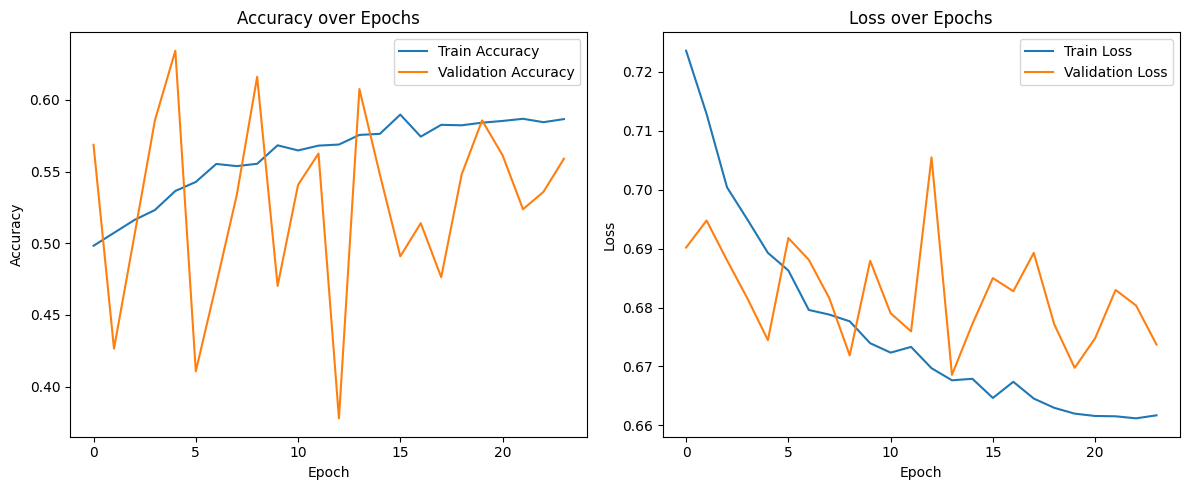

In [36]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Fine-Tuning

In [37]:
# Unfreeze the last few layers of ResNet50 for fine-tuning
base_model.trainable = True
fine_tune_at = 140  # Unfreeze from this layer onward (adjust based on your experiments)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
fine_tune_epochs = 20  # Additional epochs for fine-tuning
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 24/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6005 - loss: 2.0360

289/289 ━━━━━━━━━━━━━━━━━━━━ 161s 488ms/step - accuracy: 0.6007 - loss: 2.0323 - val_accuracy: 0.6525 - val_loss: 0.6352 - learning_rate: 1.0000e-05
Epoch 25/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7113 - loss: 0.5551

289/289 ━━━━━━━━━━━━━━━━━━━━ 131s 452ms/step - accuracy: 0.7113 - loss: 0.5551 - val_accuracy: 0.7789 - val_loss: 0.4880 - learning_rate: 1.0000e-05
Epoch 26/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7411 - loss: 0.5235

289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 449ms/step - accuracy: 0.7411 - loss: 0.5235 - val_accuracy: 0.8104 - val_loss: 0.4340 - learning_rate: 1.0000e-05
Epoch 27/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 446ms/step - accuracy: 0.7640 - loss: 0.4941 - val_accuracy: 0.6683 - val_loss: 0.6359 - learning_rate: 1.0000e-05
Epoch 28/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 450ms/step - accuracy: 0.7812 - loss: 0.4585 - val_accuracy: 0.6160 - val_loss: 0.7513 - learning_rate: 1.0000e-05
Epoch 29/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 449ms/step - accuracy: 0.7863 - loss: 0.4389 - val_accuracy: 0.6792 - val_loss: 0.6322 - learning_rate: 1.0000e-05
Epoch 30/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 447ms/step - accuracy: 0.7968 - loss: 0.4334 - val_accuracy: 0.6829 - val_loss: 0.6351 - learning_rate: 1.0000e-05
Epoch 31/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8109 - loss: 0.4029

289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 451ms/step - accuracy: 0.8109 - loss: 0.4028 - val_accuracy: 0.8275 - val_loss: 0.4051 - learning_rate: 1.0000e-05
Epoch 32/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8118 - loss: 0.4057

289/289 ━━━━━━━━━━━━━━━━━━━━ 131s 453ms/step - accuracy: 0.8118 - loss: 0.4057 - val_accuracy: 0.8384 - val_loss: 0.3539 - learning_rate: 1.0000e-05
Epoch 33/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 442ms/step - accuracy: 0.8219 - loss: 0.3955 - val_accuracy: 0.7898 - val_loss: 0.4879 - learning_rate: 1.0000e-05
Epoch 34/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8338 - loss: 0.3726

289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 443ms/step - accuracy: 0.8338 - loss: 0.3725 - val_accuracy: 0.8603 - val_loss: 0.3531 - learning_rate: 1.0000e-05
Epoch 35/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 448ms/step - accuracy: 0.8482 - loss: 0.3479 - val_accuracy: 0.8335 - val_loss: 0.3863 - learning_rate: 1.0000e-05
Epoch 36/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 439ms/step - accuracy: 0.8504 - loss: 0.3363 - val_accuracy: 0.8311 - val_loss: 0.3803 - learning_rate: 1.0000e-05
Epoch 37/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 440ms/step - accuracy: 0.8486 - loss: 0.3373 - val_accuracy: 0.8469 - val_loss: 0.3699 - learning_rate: 1.0000e-05
Epoch 38/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 443ms/step - accuracy: 0.8559 - loss: 0.3187 - val_accuracy: 0.8177 - val_loss: 0.4447 - learning_rate: 1.0000e-05
Epoch 39/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8641 - loss: 0.3141

289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 449ms/step - accuracy: 0.8640 - loss: 0.3141 - val_accuracy: 0.8663 - val_loss: 0.3105 - learning_rate: 1.0000e-05
Epoch 40/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 447ms/step - accuracy: 0.8701 - loss: 0.2926 - val_accuracy: 0.8676 - val_loss: 0.3338 - learning_rate: 1.0000e-05
Epoch 41/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 445ms/step - accuracy: 0.8742 - loss: 0.2931 - val_accuracy: 0.8554 - val_loss: 0.3265 - learning_rate: 1.0000e-05
Epoch 42/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 444ms/step - accuracy: 0.8665 - loss: 0.3079 - val_accuracy: 0.8603 - val_loss: 0.3136 - learning_rate: 1.0000e-05
Epoch 43/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8754 - loss: 0.2806

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 447ms/step - accuracy: 0.8754 - loss: 0.2806 - val_accuracy: 0.8846 - val_loss: 0.2924 - learning_rate: 1.0000e-05
Epoch 44/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8749 - loss: 0.2866

289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 443ms/step - accuracy: 0.8749 - loss: 0.2866 - val_accuracy: 0.8858 - val_loss: 0.2798 - learning_rate: 1.0000e-05
Epoch 45/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 441ms/step - accuracy: 0.8821 - loss: 0.2700 - val_accuracy: 0.8165 - val_loss: 0.4030 - learning_rate: 1.0000e-05
Epoch 46/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 444ms/step - accuracy: 0.8883 - loss: 0.2623 - val_accuracy: 0.8615 - val_loss: 0.3065 - learning_rate: 1.0000e-05
Epoch 47/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 441ms/step - accuracy: 0.8863 - loss: 0.2677 - val_accuracy: 0.8542 - val_loss: 0.3312 - learning_rate: 1.0000e-05
Epoch 48/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 442ms/step - accuracy: 0.8923 - loss: 0.2656 - val_accuracy: 0.8748 - val_loss: 0.2952 - learning_rate: 1.0000e-05
Epoch 49/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8888 - loss: 0.2535

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 446ms/step - accuracy: 0.8888 - loss: 0.2535 - val_accuracy: 0.8979 - val_loss: 0.2564 - learning_rate: 1.0000e-05
Epoch 50/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8945 - loss: 0.2503

289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 450ms/step - accuracy: 0.8945 - loss: 0.2503 - val_accuracy: 0.9101 - val_loss: 0.2432 - learning_rate: 1.0000e-05
Epoch 51/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 441ms/step - accuracy: 0.8953 - loss: 0.2480 - val_accuracy: 0.8748 - val_loss: 0.3201 - learning_rate: 1.0000e-05
Epoch 52/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 441ms/step - accuracy: 0.9038 - loss: 0.2369 - val_accuracy: 0.8870 - val_loss: 0.2725 - learning_rate: 1.0000e-05
Epoch 53/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8924 - loss: 0.2427

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 446ms/step - accuracy: 0.8924 - loss: 0.2427 - val_accuracy: 0.9149 - val_loss: 0.2336 - learning_rate: 1.0000e-05
Epoch 54/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 445ms/step - accuracy: 0.9000 - loss: 0.2336 - val_accuracy: 0.8761 - val_loss: 0.2702 - learning_rate: 1.0000e-05
Epoch 55/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 126s 438ms/step - accuracy: 0.8956 - loss: 0.2443 - val_accuracy: 0.9198 - val_loss: 0.2353 - learning_rate: 1.0000e-05
Epoch 56/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 444ms/step - accuracy: 0.9079 - loss: 0.2259 - val_accuracy: 0.8663 - val_loss: 0.3320 - learning_rate: 1.0000e-05
Epoch 57/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 131s 453ms/step - accuracy: 0.8925 - loss: 0.2436 - val_accuracy: 0.8809 - val_loss: 0.2898 - learning_rate: 1.0000e-05
Epoch 58/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9022 - loss: 0.2278

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 447ms/step - accuracy: 0.9022 - loss: 0.2278 - val_accuracy: 0.9077 - val_loss: 0.2165 - learning_rate: 1.0000e-05
Epoch 59/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 445ms/step - accuracy: 0.9103 - loss: 0.2138 - val_accuracy: 0.8639 - val_loss: 0.3373 - learning_rate: 1.0000e-05
Epoch 60/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 441ms/step - accuracy: 0.9114 - loss: 0.2197 - val_accuracy: 0.8724 - val_loss: 0.3045 - learning_rate: 1.0000e-05
Epoch 61/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9146 - loss: 0.2089

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 445ms/step - accuracy: 0.9146 - loss: 0.2089 - val_accuracy: 0.9101 - val_loss: 0.2053 - learning_rate: 1.0000e-05
Epoch 62/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 441ms/step - accuracy: 0.9204 - loss: 0.2064 - val_accuracy: 0.9004 - val_loss: 0.2728 - learning_rate: 1.0000e-05
Epoch 63/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 439ms/step - accuracy: 0.9180 - loss: 0.2070 - val_accuracy: 0.8153 - val_loss: 0.4402 - learning_rate: 1.0000e-05
Epoch 64/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 444ms/step - accuracy: 0.9239 - loss: 0.1925 - val_accuracy: 0.9016 - val_loss: 0.2360 - learning_rate: 1.0000e-05
Epoch 65/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 444ms/step - accuracy: 0.9205 - loss: 0.1957 - val_accuracy: 0.8882 - val_loss: 0.2534 - learning_rate: 1.0000e-05
Epoch 66/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 440ms/step - accuracy: 0.9153 - loss: 0.2018 - val_accuracy: 0.8955 - val_loss: 0.2404 - learning_rate: 1.0000e-05
Epoch 67/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 

289/289 ━━━━━━━━━━━━━━━━━━━━ 129s 448ms/step - accuracy: 0.9322 - loss: 0.1759 - val_accuracy: 0.9259 - val_loss: 0.1949 - learning_rate: 5.0000e-06
Epoch 69/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9294 - loss: 0.1716

289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 446ms/step - accuracy: 0.9294 - loss: 0.1715 - val_accuracy: 0.9222 - val_loss: 0.1776 - learning_rate: 5.0000e-06
Epoch 70/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 128s 442ms/step - accuracy: 0.9402 - loss: 0.1447 - val_accuracy: 0.9052 - val_loss: 0.2178 - learning_rate: 5.0000e-06


## Save and Deploy

In [40]:
model.save('bone_fracture_classifier.h5')

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

In [43]:
# Save the model
model_pre = tf.keras.models.clone_model(model)
model_pre.set_weights(model.get_weights())

## More Stats and Vis

In [44]:
# Use the pre-tuned model to predict the test set
Y_pred_pre = model_pre.predict(test_generator)
y_pred_pre = np.argmax(Y_pred_pre, axis=1)

# Get true labels from the test generator
true_labels = test_generator.classes

# Compute the confusion matrix
cm_pre = confusion_matrix(true_labels, y_pred_pre)

# print the classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report - Pre-Tuned Model")
print(classification_report(true_labels, y_pred_pre, target_names=class_names))

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
Classification Report - Pre-Tuned Model
               precision    recall  f1-score   support

    fractured       0.90      0.97      0.93       238
not fractured       0.97      0.90      0.93       262

     accuracy                           0.93       500
    macro avg       0.93      0.93      0.93       500
 weighted avg       0.93      0.93      0.93       500



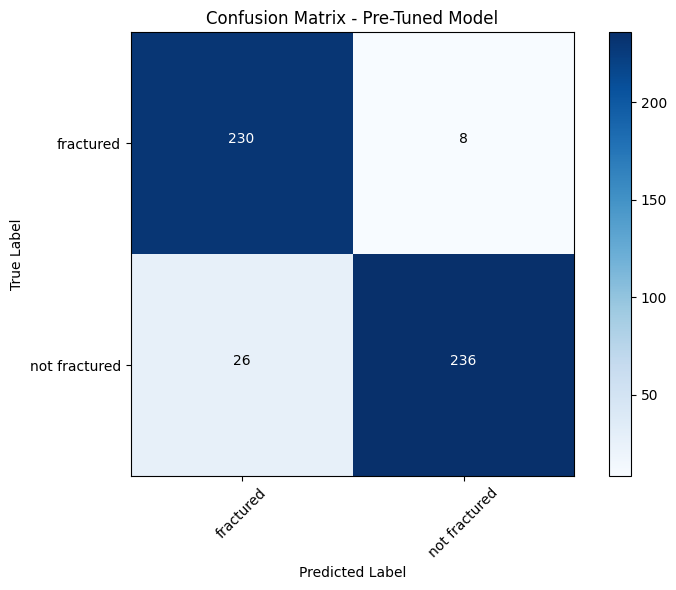

In [45]:
plt.figure(figsize=(8, 6))
plt.imshow(cm_pre, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Pre-Tuned Model")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm_pre.max() / 2.0
for i, j in itertools.product(range(cm_pre.shape[0]), range(cm_pre.shape[1])):
    plt.text(j, i, format(cm_pre[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_pre[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()